# Prerequisites

In [1]:
!pip freeze

absl-py==1.4.0
-e git+https://github.com/geronimi73/accelerate@d25a787628e42ef9efcc165807ba7aa9fa9d56ae#egg=accelerate
addict==2.4.0
aenum==3.1.15
aiodns==3.1.1
aiofiles==23.1.0
aiohttp==3.9.2
aiohttp-retry==2.8.3
aiosignal==1.3.1
altair==5.1.1
annotated-types==0.6.0
antlr4-python3-runtime==4.9.3
anyio==3.7.1
apache-beam==2.52.0
appdirs==1.4.4
apturl==0.5.2
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attributedict==0.3.0
attrs==23.1.0
autoawq==0.1.8
Babel==2.13.1
backoff==2.2.1
basicsr==1.4.2
bcrypt==3.2.0
beautifulsoup4==4.10.0
beniget==0.4.1
bitsandbytes==0.42.0
black==23.12.1
bleach==6.1.0
blendmodes==2022
blessings==1.7
blinker==1.4
boltons==23.0.0
boto3==1.34.34
botocore==1.34.34
bottle==0.12.19
Brlapi==0.8.3
Brotli==1.1.0
cached-property==1.5.2
cachetools==5.3.2
cattrs==23.2.3
causal-conv1d==1.0.0
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.2.0
ci-info==0.3.0
clean

# Load LMSYS Arena conversations and calculate semscore model-x vs. GPT4 and correlate this with ELO
* wrap embedding model
* load arena conversations
* calculate average similarity for each model against GPT4
* show correlation of raw values and ranking with each approach

## embedding model wrapper

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch, gc
import torch.nn as nn

class EmbeddingModelWrapper():
    def __init__(self, model_path="sentence-transformers/all-mpnet-base-v2", bs=8):
        self.model, self.tokenizer = self.load_model(model_path)
        self.bs = bs
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def load_model(self, model_path):
        model = AutoModel.from_pretrained(model_path).cuda()
        model.eval()
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        return model, tokenizer

    def emb_mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, sentences):
        embeddings = torch.tensor([],device="cuda")
        
        if self.bs is None:
            batches = [sentences]
        else:
            batches = [sentences[i:i + self.bs] for i in range(0, len(sentences), self.bs)]  
            
        for sentences in batches:
            encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to("cuda")
            with torch.no_grad():
                model_output = self.model(**encoded_input)        
            batch_embeddings=self.emb_mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings=torch.cat( (embeddings, batch_embeddings), dim=0 )

        return embeddings.cpu()

    def get_similarities(self, x, y=None):
        if y is None:
            num_samples=x.shape[0]
            similarities = [[0 for i in range(num_samples)] for f in range(num_samples)]
            for row in range(num_samples):
                for col in range(row+1):
                    similarities[row][col] = self.cos(x[row].unsqueeze(0), x[col].unsqueeze(0)).item()
            return similarities
        else:            
            return self.cos(x,y).tolist()

test the embedding model wrapper with our previous three word example

In [21]:
em = EmbeddingModelWrapper()

/home/g/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## load arena conversations

In [1]:
from datasets import load_dataset

dataset = load_dataset("lmsys/chatbot_arena_conversations")["train"]
dataset

Dataset({
    features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn', 'anony', 'language', 'tstamp', 'openai_moderation', 'toxic_chat_tag'],
    num_rows: 33000
})

### get a feeling for the data

In [6]:
# look at first row
import json
print(json.dumps(dataset[0], indent=2))

{
  "question_id": "58210e39b3fd4441a2bd4a518bb44c2d",
  "model_a": "chatglm-6b",
  "model_b": "koala-13b",
  "winner": "model_b",
  "judge": "arena_user_973",
  "conversation_a": [
    {
      "content": "What is the difference between OpenCL and CUDA?",
      "role": "user"
    },
    {
      "content": "OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL is a general-purpose\u5e76\u884c\u7f16\u7a0b\u63a5\u53e3 that allows developers to write parallel code that can run on any platform that supportsCL, which includes most modern operating systems and computer systems, including Windows, Linux, and macOS. It provides a lower-level, more flexible API that is more suitable for building large-scale distributed computing systems.CUDA is a specific implementation ofOpenCL that is designed for performance and scalability in devices with multiple GPU(s). It was developed by Nvidia and is widely used for scientific computing, machine learning, and\u

In [2]:
# how many conversation per model?
model_conv_count={}
for d in dataset:
    for k in ["model_a", "model_b"]:
        model=d[k]
        if not model in model_conv_count: 
            model_conv_count[model]=1
        else:
            model_conv_count[model]+=1    
model_conv_count

{'chatglm-6b': 3322,
 'koala-13b': 5573,
 'oasst-pythia-12b': 4890,
 'alpaca-13b': 4453,
 'vicuna-13b': 5931,
 'dolly-v2-12b': 2786,
 'stablelm-tuned-alpha-7b': 2795,
 'llama-13b': 2009,
 'fastchat-t5-3b': 3210,
 'gpt-3.5-turbo': 4654,
 'gpt-4': 4217,
 'RWKV-4-Raven-14B': 3682,
 'claude-v1': 3927,
 'mpt-7b-chat': 2854,
 'palm-2': 2955,
 'claude-instant-v1': 2626,
 'vicuna-7b': 2869,
 'wizardlm-13b': 1116,
 'gpt4all-13b-snoozy': 1097,
 'guanaco-33b': 1034}

## extract all conversation where GPT4 gave one of the two answers

In [18]:
from tqdm import tqdm 

reference_model="gpt-4"
answers={}

for judgement in tqdm(dataset):
	# skip duels without GPT4
    models_involved = judgement["model_a"] + judgement["model_b"]
    if not reference_model in models_involved:
        continue    

    # get answers for GPT-4 and other model
    reference_label, other_label= ("a", "b") if judgement["model_a"] == reference_model else ("b", "a")
    answers_ref = [ msg["content"] for msg in judgement[f"conversation_{reference_label}"] if msg["role"]=="assistant" ] 
    answers_other = [ msg["content"] for msg in judgement[f"conversation_{other_label}"] if msg["role"]=="assistant" ] 

    # store answers in answers dict
    other_model = judgement[f"model_{other_label}"]    
    if not other_model in answers:
        answers[other_model]=dict(answers_model=[], answers_ref=[])
    answers[other_model]["answers_model"].extend(answers_other)
    answers[other_model]["answers_ref"].extend(answers_ref)

100%|███████████████████████████████████| 33000/33000 [00:04<00:00, 7112.22it/s]


In [19]:
import pandas as pd 

data = {
    'Model': answers.keys(),
    'num_answers': [len(answers[m]["answers_model"]) for m in answers],
}

df = pd.DataFrame(data)
df = df.sort_values(by=['num_answers'], ascending=False)
df

,Model,num_answers
0,vicuna-13b,448
3,gpt-3.5-turbo,436
2,koala-13b,417
1,oasst-pythia-12b,395
10,claude-v1,366
11,RWKV-4-Raven-14B,346
9,alpaca-13b,290
6,chatglm-6b,266
5,fastchat-t5-3b,258
12,mpt-7b-chat,258


In [29]:
print(answers["vicuna-13b"]["answers_model"][6])

If your dog has eaten some chocolate, the first thing you should do is to try to determine how much chocolate they have eaten and what type of chocolate it was. The darker and more bitter the chocolate, the more dangerous it is for your dog.

If your dog has only eaten a small amount of chocolate, they may not show any symptoms at all. However, if they have eaten a larger amount, they may experience symptoms such as vomiting, diarrhea, increased heart rate, and agitation. In severe cases, chocolate poisoning can lead to seizures, coma, and even death.

If you suspect that your dog has eaten chocolate, it's important to contact a veterinarian right away. Your veterinarian will be able to determine the severity of the situation and provide appropriate treatment. In some cases, your veterinarian may recommend inducing vomiting to remove the chocolate from your dog's stomach. In other cases, they may need to administer activated charcoal or other medications to help remove the chocolate fr

In [30]:
print(answers["vicuna-13b"]["answers_ref"][6])

I'm not a veterinarian, but if your dog has eaten chocolate, it's important to act quickly as chocolate can be toxic to dogs. Here are some steps you might consider:

1. Determine the amount and type of chocolate your dog consumed. Dark chocolate and baking chocolate are more toxic than milk chocolate.

2. Check for symptoms of chocolate poisoning, which may include vomiting, diarrhea, rapid breathing, increased heart rate, and seizures.

3. Call your veterinarian or a pet poison helpline immediately. They can provide guidance based on the specific situation.

4. Follow the advice of the veterinarian or the helpline, which may include inducing vomiting, administering activated charcoal, or taking your dog to the vet for treatment.

Remember to consult a professional for advice tailored to your dog's specific situation.


In [33]:
similarities = em.get_similarities(
    em.get_embeddings([ answers["vicuna-13b"]["answers_model"][6] ]),
    em.get_embeddings([ answers["vicuna-13b"]["answers_ref"][6] ]),
)
round(similarities[0], 3)

0.958

In [37]:
from statistics import mean
similarities = em.get_similarities(
    em.get_embeddings(answers["vicuna-13b"]["answers_model"]),
    em.get_embeddings(answers["vicuna-13b"]["answers_ref"]),
)
round(mean(similarities), 3)

0.77

In [38]:
from statistics import mean

models=list(answers.keys())
models_similarities=[]

for model in tqdm(models):
    similarities = em.get_similarities(
        em.get_embeddings(answers[model]["answers_model"]),
        em.get_embeddings(answers[model]["answers_ref"]),
    )
    models_similarities.append( mean(similarities) )

100%|███████████████████████████████████████████| 19/19 [01:37<00:00,  5.11s/it]


In [41]:
import pandas as pd 

data = {
    'Model': answers.keys(),
    'num_answers': [len(answers[m]["answers_model"]) for m in answers],
    'SemScore': models_similarities,
}

df = pd.DataFrame(data)
df = df.sort_values(by=['SemScore'], ascending=False)
df

,Model,num_answers,SemScore
17,wizardlm-13b,73,0.813826
10,claude-v1,366,0.801175
3,gpt-3.5-turbo,436,0.799797
15,claude-instant-v1,191,0.773934
0,vicuna-13b,448,0.769672
18,guanaco-33b,90,0.765226
14,vicuna-7b,249,0.740022
2,koala-13b,417,0.711215
5,fastchat-t5-3b,258,0.709203
16,gpt4all-13b-snoozy,80,0.708363


In [44]:
elo_ratings_raw = \
"""1	gpt-4-turbo	1250
2	bard-jan-24-gemini-pro	1214
3	gpt-4-0314	1189
4	gpt-4-0613	1161
5	mistral-medium	1150
6	claude-1	1150
7	claude-2.0	1131
8	mixtral-8x7b-instruct-v0.1	1122
9	gemini-pro-dev-api	1122
10	claude-2.1	1119
11	gpt-3.5-turbo-0613	1117
12	gemini-pro	1114
13	yi-34b-chat	1112
14	claude-instant-1	1110
15	wizardlm-70b	1106
16	tulu-2-dpo-70b	1105
17	gpt-3.5-turbo-0314	1104
18	deepseek-llm-67b-chat	1099
19	vicuna-33b	1094
20	starling-lm-7b-alpha	1089
21	llama-2-70b-chat	1081
22	llama2-70b-steerlm-chat	1078
23	openchat-3.5	1077
24	openhermes-2.5-mistral-7b	1076
25	pplx-70b-online	1074
26	gpt-3.5-turbo-1106	1072
27	solar-10.7b-instruct-v1.0	1065
28	dolphin-2.2.1-mistral-7b	1064
29	wizardlm-13b	1058
30	zephyr-7b-beta	1050
31	mpt-30b-chat	1043
32	codellama-34b-instruct	1042
33	vicuna-13b	1040
34	llama-2-13b-chat	1039
35	zephyr-7b-alpha	1037
36	pplx-7b-online	1036
37	qwen-14b-chat	1034
38	falcon-180b-chat	1032
39	guanaco-33b	1031
40	llama-2-7b-chat	1021
41	stripedhyena-nous-7b	1017
42	mistral-7b-instruct	1010
43	palm-2	1005
44	vicuna-7b	1005
45	koala-13b	965
46	chatglm3-6b	960
47	gpt4all-13b-snoozy	937
48	mpt-7b-chat	930
49	chatglm2-6b	929
50	RWKV-4-Raven-14B	924
51	alpaca-13b	904
52	oasst-pythia-12b	896
53	chatglm-6b	883
54	fastchat-t5-3b	874
55	stablelm-tuned-alpha-7b	844
56	dolly-v2-12b	822
57	llama-13b	800"""

elo_ratings={}

for line in elo_ratings_raw.split("\n"):
    line_split=line.split("\t")
    model=line_split[1]
    elo=line_split[2]
    elo_ratings[model]=elo

model_map_elo = {
    "claude-v1": "claude-1",
    "gpt-3.5-turbo": "gpt-3.5-turbo-0613",
    "claude-instant-v1": "claude-instant-1"
}
model_elo=[]
for model in models:
    model_elo_name=model if not model in model_map_elo else model_map_elo[model]
    elo=elo_ratings[model_elo_name] if model_elo_name in elo_ratings else None
    model_elo.append(int(elo))

In [57]:
import pandas as pd 

data = {
    'Model': answers.keys(),
    'num_answers': [len(answers[m]["answers_model"]) for m in answers],
    'ELO': model_elo,
    'SemScore': models_similarities,
    "rank_ELO": [ sorted(model_elo, reverse=True).index(x)+1 for x in model_elo ],    
    "rank_SemScore": [ sorted(models_similarities, reverse=True).index(x)+1 for x in models_similarities ],    
}

df = pd.DataFrame(data)
df = df.sort_values(by=['rank_SemScore'], ascending=True)
df

,Model,num_answers,ELO,SemScore,rank_ELO,rank_SemScore
17,wizardlm-13b,73,1058,0.813826,4,1
10,claude-v1,366,1150,0.801175,1,2
3,gpt-3.5-turbo,436,1117,0.799797,2,3
15,claude-instant-v1,191,1110,0.773934,3,4
0,vicuna-13b,448,1040,0.769672,5,5
18,guanaco-33b,90,1031,0.765226,6,6
14,vicuna-7b,249,1005,0.740022,7,7
2,koala-13b,417,965,0.711215,9,8
5,fastchat-t5-3b,258,874,0.709203,16,9
16,gpt4all-13b-snoozy,80,937,0.708363,10,10


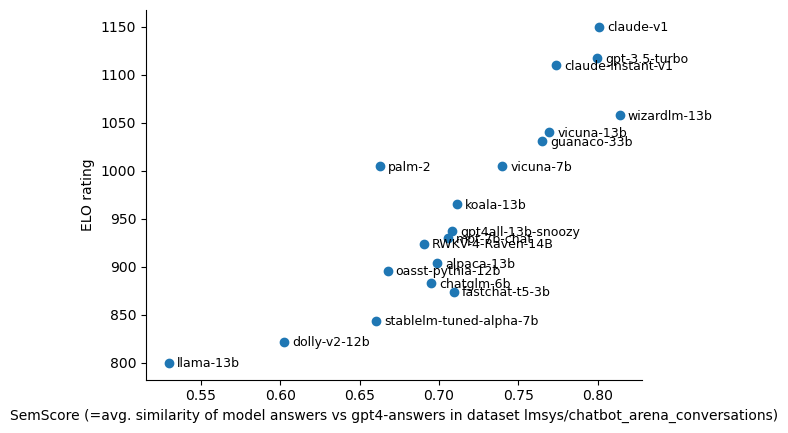

In [58]:
import matplotlib.pyplot as plt

plt.scatter(models_similarities, model_elo)

plt.xlabel('SemScore (=avg. similarity of model answers vs gpt4-answers in dataset lmsys/chatbot_arena_conversations)')
plt.ylabel('ELO rating')

for i, model in enumerate(models):
    plt.text(models_similarities[i]+0.005, model_elo[i]-8, model, fontsize=9, ha='left', va='bottom')

plt.gca().spines['top'].set_visible(False)    # Hide top border
plt.gca().spines['right'].set_visible(False)  # Hide right border

plt.show()

In [60]:
pcc = df['ELO'].corr(df['SemScore'])

print(f"Pearson Correlation Coefficient between 'sim' and 'elo': {pcc}")

Pearson Correlation Coefficient between 'sim' and 'elo': 0.8717345534594959


In [61]:
# low sample models
[m for m in answers if len(answers[m]["answers_model"])<100]

['gpt4all-13b-snoozy', 'wizardlm-13b', 'guanaco-33b']